In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [32]:
reviews = pd.read_csv('IMDB Dataset.csv')
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


# Prepare the data for input into the model

In [33]:
# the numpy .where function is used here to turn positive sentiment to 1 (integer) and negative to 0
# this is to allow the model to use the data (it needs to be in intger form)
reviews['sentiment'] = np.where(reviews['sentiment'] == 'positive', 1, 0)

reviews.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [34]:
# convert the two rows of the pandas dataframe to numpy arrays

# the sentences represent each review.
# the labels are the sentiment of each review
sentences = reviews['review'].to_numpy()
labels = reviews['sentiment'].to_numpy()


In [36]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=0.25)
print("Training Data Input Shape: ", X_train.shape)
print("Training Data Output Shape: ", y_train.shape)
print("Testing Data Input Shape: ", X_test.shape)
print("Testing Data Output Shape: ", y_test.shape)

Training Data Input Shape:  (37500,)
Training Data Output Shape:  (37500,)
Testing Data Input Shape:  (12500,)
Testing Data Output Shape:  (12500,)


In [37]:
# vacab size limits the vocab of the model: to the top 10,000 words in this case.

# the oov token allows the model to deal with words that are not in its vocabulary.
# without this a word that is not in the vocab of the model could break it.

vocab_size = 10000
oov_tok = "<OOV>"
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

In [38]:
# we are now converting the words to integer values and building up the models vocabulary.
tokenizer.fit_on_texts(X_train)
print("Number of Documents: ", tokenizer.document_count)
print("Number of Words: ", tokenizer.num_words)

Number of Documents:  37500
Number of Words:  10000


In [39]:
tokenizer.word_counts

OrderedDict([('what', 23048),
             ('is', 158086),
             ('this', 113123),
             ('its', 11992),
             ('so', 30422),
             ('bad', 13614),
             ('the', 498560),
             ('animation', 1077),
             ('looks', 3335),
             ('terrible', 2483),
             ('it', 117440),
             ('like', 29878),
             ('a', 241331),
             ('ps1', 11),
             ('type', 1733),
             ('game', 2007),
             ('actors', 6681),
             ('are', 43426),
             ('awful', 2579),
             ('they', 31197),
             ('just', 26329),
             ('cannot', 1565),
             ('act', 1841),
             ('to', 200543),
             ('save', 1539),
             ('their', 16941),
             ('lives', 2027),
             ('i', 116129),
             ('sat', 441),
             ('through', 7179),
             ('all', 34884),
             ('of', 215590),
             ('film', 57652),
             ('an', 321

In [ ]:
tokenizer.word_docs

defaultdict(int,
            {'in': 33035,
             'better': 6978,
             'one': 21201,
             'you': 19502,
             'to': 35224,
             "i've": 4119,
             'after': 8486,
             'through': 5778,
             'recommend': 2452,
             'worst': 3346,
             'animation': 740,
             'annoying': 1267,
             'awful': 2159,
             'realised': 106,
             'watching': 5657,
             'out': 15971,
             'that': 29931,
             'it': 31824,
             'with': 26068,
             'straight': 1127,
             'heard': 1548,
             'time': 12962,
             'ah': 172,
             'film': 20573,
             'copied': 78,
             'would': 11949,
             'actors': 5429,
             'like': 17350,
             'all': 19365,
             'its': 7654,
             'ever': 7253,
             'i': 28809,
             'type': 1539,
             'people': 9082,
             'was': 24106,
   

In [ ]:
tokenizer.word_index

In [101]:
# this converts each review into a sequence of integers which represent the words in that review
train_sequences = tokenizer.texts_to_sequences(X_train)
print(train_sequences[0])

[166, 4313, 4314, 293, 400]


In [103]:
# this padds all the reviews so that they are all the same size
# it adds 0's to make them all list which have a length of 200.

sequence_length = 200
train_padded = pad_sequences(train_sequences, maxlen=sequence_length, padding='post', truncating='post')

array([[ 166, 4313, 4314, ...,    0,    0,    0],
       [ 197,    0,    0, ...,    0,    0,    0],
       [  23,  401, 1200, ...,    0,    0,    0],
       ...,
       [1223,  265, 1207, ...,    0,    0,    0],
       [ 621,   65,  446, ...,    0,    0,    0],
       [4154, 1899, 1304, ...,    0,    0,    0]], dtype=int32)

In [104]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=sequence_length, padding='post', truncating='post')


# create the model

In [105]:
model = Sequential()

embedding_dim = 16
model.add(Embedding(vocab_size, embedding_dim, input_length=sequence_length))

lstm_out = 32
model.add(Bidirectional(LSTM(lstm_out)))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 173,205
Trainable params: 173,205
Non-trainable params: 0
_________________________________________________________________


In [45]:
# this just sets the path for saving the model parameters into the current working directory

checkpoint_filepath = os.getcwd()
model_checkpoint_callback = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_loss', mode='min', save_best_only=True)

# this is where the early stopping is defined
# it stops computing epochs when it thinks overfitting is happening
callbacks = [EarlyStopping(patience=2), model_checkpoint_callback]

In [46]:
history = model.fit(train_padded, y_train, epochs=10, validation_data=(test_padded, y_test), callbacks=callbacks)

Epoch 1/10


2023-04-11 13:19:13.160970: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1171/1172 [============================>.] - ETA: 0s - loss: 0.5819 - accuracy: 0.6888

1172/1172 [==============================] - 44s 36ms/step - loss: 0.5819 - accuracy: 0.6889 - val_loss: 0.6206 - val_accuracy: 0.6718
Epoch 2/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.4329 - accuracy: 0.8024

1172/1172 [==============================] - 43s 36ms/step - loss: 0.4328 - accuracy: 0.8025 - val_loss: 0.3809 - val_accuracy: 0.8487
Epoch 3/10
1171/1172 [============================>.] - ETA: 0s - loss: 0.2753 - accuracy: 0.8891

1172/1172 [==============================] - 43s 37ms/step - loss: 0.2752 - accuracy: 0.8892 - val_loss: 0.3177 - val_accuracy: 0.8689
Epoch 4/10
1172/1172 [==============================] - 40s 34ms/step - loss: 0.2299 - accuracy: 0.9116 - val_loss: 0.3305 - val_accuracy: 0.8630
Epoch 5/10
1172/1172 [==============================] - 39s 33ms/step - loss: 0.1994 - accuracy: 0.9248 - val_loss: 0.3246 - val_accuracy: 0.8689


In [47]:
metrics_df = pd.DataFrame(history.history)
print(metrics_df)

       loss  accuracy  val_loss  val_accuracy
0  0.581915  0.688853  0.620586       0.67176
1  0.432799  0.802453  0.380855       0.84872
2  0.275241  0.889173  0.317734       0.86888
3  0.229920  0.911627  0.330506       0.86304
4  0.199392  0.924773  0.324632       0.86888


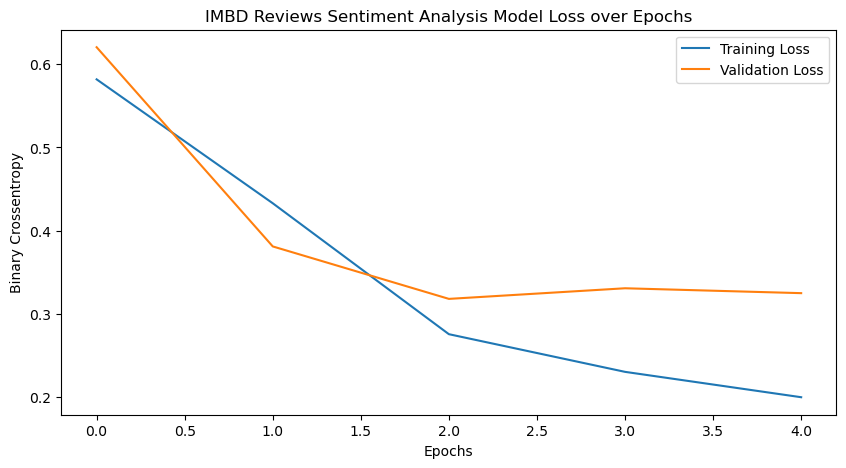

In [48]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.loss)
plt.plot(metrics_df.index, metrics_df.val_loss)
plt.title('IMBD Reviews Sentiment Analysis Model Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy')
plt.legend(['Training Loss', 'Validation Loss'])
plt.show()

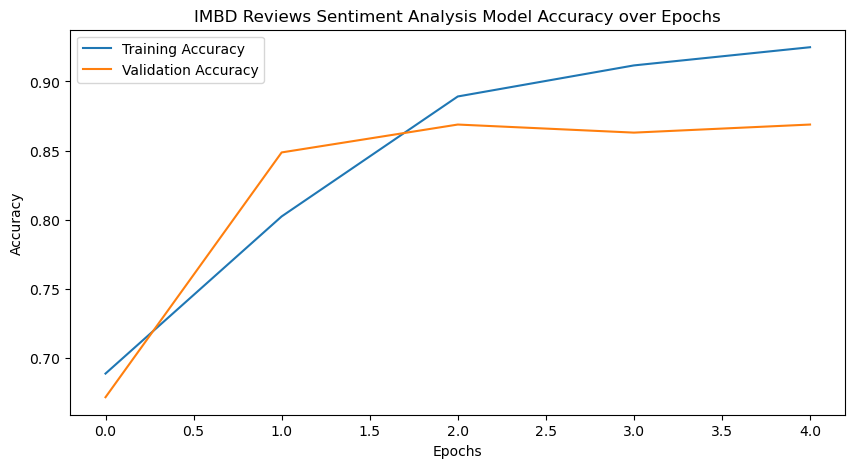

In [49]:
plt.figure(figsize=(10,5))
plt.plot(metrics_df.index, metrics_df.accuracy)
plt.plot(metrics_df.index, metrics_df.val_accuracy)
plt.title('IMBD Reviews Sentiment Analysis Model Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.show()

## Text Classification

In [50]:
import tensorflow as tf
from tensorflow                              import keras
from tensorflow.keras                        import layers, Sequential
from tensorflow.keras.preprocessing.text     import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics         import confusion_matrix

import pandas as pd
import numpy  as np

import matplotlib.pyplot as plt

import os
import time

import nltk
from nltk.corpus import stopwords

In [51]:
nltk.download('stopwords')
# https://www.kaggle.com/c/nlp-getting-started: NLP Disaster Tweets dataset
df = pd.read_csv("train.csv")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/samuelspeller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [52]:
df.shape

(7613, 5)

In [53]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [54]:
print((df.target == 1).sum()) # Disaster
print((df.target == 0).sum()) # No Disaster

3271
4342


In [55]:
# Preprocessing
import re
import string

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [56]:
pattern = re.compile(r"https?://(\S+|www)\.\S+")

for t in df.text:
    matches = pattern.findall(t)
    for match in matches:
        print(t)
        print(match)
        print(pattern.sub(r"", t))
    if len(matches) > 0:
        break

@bbcmtd Wholesale Markets ablaze http://t.co/lHYXEOHY6C
t
@bbcmtd Wholesale Markets ablaze 


In [57]:
df["text"] = df.text.map(remove_URL)
df["text"] = df.text.map(remove_punct)

In [58]:
# remove stopwords
#nltk.download('stopwords')

# Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine
# has been programmed to ignore, both when indexing entries for searching and when retrieving them 
# as the result of a search query.
stop = set(stopwords.words("english"))

def remove_stopwords(text):
    filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(filtered_words)

In [59]:
stop

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [60]:
df["text"] = df.text.map(remove_stopwords)

In [61]:
df.text

0            deeds reason earthquake may allah forgive us
1                   forest fire near la ronge sask canada
2       residents asked shelter place notified officer...
3       13000 people receive wildfires evacuation orde...
4       got sent photo ruby alaska smoke wildfires pou...
                              ...                        
7608    two giant cranes holding bridge collapse nearb...
7609    ariaahrary thetawniest control wild fires cali...
7610                      m194 0104 utc5km volcano hawaii
7611    police investigating ebike collided car little...
7612    latest homes razed northern california wildfir...
Name: text, Length: 7613, dtype: object

In [62]:
from collections import Counter

# Count unique words
def counter_word(text_col):
    count = Counter()
    for text in text_col.values:
        for word in text.split():
            count[word] += 1
    return count


counter = counter_word(df.text)

In [63]:
len(counter)

17971

In [64]:
counter

Counter({'deeds': 2,
         'reason': 20,
         'earthquake': 50,
         'may': 88,
         'allah': 9,
         'forgive': 2,
         'us': 164,
         'forest': 65,
         'fire': 250,
         'near': 54,
         'la': 25,
         'ronge': 1,
         'sask': 1,
         'canada': 11,
         'residents': 8,
         'asked': 9,
         'shelter': 6,
         'place': 26,
         'notified': 1,
         'officers': 8,
         'evacuation': 50,
         'orders': 11,
         'expected': 15,
         '13000': 4,
         'people': 196,
         'receive': 2,
         'wildfires': 11,
         'california': 117,
         'got': 112,
         'sent': 13,
         'photo': 41,
         'ruby': 1,
         'alaska': 6,
         'smoke': 48,
         'pours': 1,
         'school': 66,
         'rockyfire': 4,
         'update': 37,
         'hwy': 9,
         '20': 26,
         'closed': 20,
         'directions': 1,
         'due': 31,
         'lake': 14,
         'co

In [65]:
counter.most_common(5)

[('like', 345), ('im', 299), ('amp', 298), ('fire', 250), ('get', 229)]

In [66]:
num_unique_words = len(counter)
print(num_unique_words)

17971


### Creating X, y data

In [67]:
X = df.text.to_numpy()
y = df.target.to_numpy()

### Splitting the data into Training and testing

In [68]:
# TODO: Create a test train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [69]:
#print(X_train)

In [70]:
# Split dataset into training and validation set
train_size = int(X_train.shape[0] * 0.8)

train_df = X_train[:train_size]
val_df   = X_train[train_size:]

#print(train_df)

In [71]:
# split text and labels
train_sentences = train_df
train_labels    = y_train[:train_size]
val_sentences   = val_df
val_labels      = y_train[train_size:]

In [72]:
#train_sentences.shape, val_sentences.shape

In [73]:
test_sentences = X_test
test_labels    = y_test

In [74]:
test_sentences.shape

(2513,)

In [75]:
# Tokenize
# vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=num_unique_words)
tokenizer.fit_on_texts(train_sentences) # fit only to training

In [76]:
# each word has unique index
word_index = tokenizer.word_index

In [77]:
#word_index

In [78]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences  = tokenizer.texts_to_sequences(test_sentences)
val_sequences   = tokenizer.texts_to_sequences(val_sentences)

In [79]:
print(train_sentences[10:15])
print(train_sequences[10:15])

['onufrance 7475 bioterrorism rockefellerchirockefellerunivheiress 2 evade lgl efforts 2 prosecute blks 4 harvardu kidnapgafp'
 'noahanyname utopian impulse inevitably ends gulags mass murder'
 'dreaming peacefully loud ass thunder wanted scare'
 'swellyjetevo disneyland tacos bomb'
 'blood pressure roof dont need extra shit']
[[4325, 4326, 493, 4327, 14, 4328, 4329, 2085, 14, 4330, 4331, 107, 4332, 4333], [2782, 4334, 4335, 4336, 1399, 4337, 66, 153], [4338, 4339, 218, 167, 154, 833, 2783], [4340, 4341, 4342, 53], [265, 1207, 1665, 11, 91, 2784, 132]]


In [80]:
# Pad the sequences to have the same length
# Max number of words in a sequence
max_length = 20

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding="post", truncating="post")
val_padded   = pad_sequences(val_sequences, maxlen=max_length, padding="post", truncating="post")

In [81]:
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding="post", truncating="post")

In [82]:
train_padded.shape, test_padded.shape, val_padded.shape

((4080, 20), (2513, 20), (1020, 20))

In [83]:
train_padded[10]

array([4325, 4326,  493, 4327,   14, 4328, 4329, 2085,   14, 4330, 4331,
        107, 4332, 4333,    0,    0,    0,    0,    0,    0], dtype=int32)

In [84]:
print(train_sentences[10])
print(train_sequences[10])
print(train_padded[10])

onufrance 7475 bioterrorism rockefellerchirockefellerunivheiress 2 evade lgl efforts 2 prosecute blks 4 harvardu kidnapgafp
[4325, 4326, 493, 4327, 14, 4328, 4329, 2085, 14, 4330, 4331, 107, 4332, 4333]
[4325 4326  493 4327   14 4328 4329 2085   14 4330 4331  107 4332 4333
    0    0    0    0    0    0]


In [85]:
# Check reversing the indices

# flip (key, value)
reverse_word_index = dict([(idx, word) for (word, idx) in word_index.items()])

In [86]:
reverse_word_index

{1: 'like',
 2: 'im',
 3: 'amp',
 4: 'fire',
 5: 'new',
 6: 'via',
 7: 'get',
 8: 'people',
 9: 'news',
 10: 'one',
 11: 'dont',
 12: 'us',
 13: 'video',
 14: '2',
 15: 'emergency',
 16: 'disaster',
 17: 'still',
 18: 'police',
 19: 'would',
 20: 'california',
 21: 'crash',
 22: 'world',
 23: 'man',
 24: 'suicide',
 25: 'know',
 26: 'train',
 27: 'time',
 28: '3',
 29: 'day',
 30: 'body',
 31: 'go',
 32: 'burning',
 33: 'see',
 34: 'got',
 35: 'buildings',
 36: 'first',
 37: 'nuclear',
 38: 'attack',
 39: 'car',
 40: 'youtube',
 41: 'fires',
 42: 'rt',
 43: 'back',
 44: 'cant',
 45: 'families',
 46: 'storm',
 47: 'today',
 48: 'war',
 49: 'watch',
 50: 'life',
 51: 'hiroshima',
 52: 'good',
 53: 'bomb',
 54: 'going',
 55: 'look',
 56: 'two',
 57: 'u',
 58: 'may',
 59: 'full',
 60: 'love',
 61: 'dead',
 62: 'accident',
 63: 'think',
 64: 'way',
 65: 'say',
 66: 'mass',
 67: 'army',
 68: 'wildfire',
 69: 'many',
 70: 'years',
 71: 'black',
 72: 'last',
 73: 'best',
 74: 'death',
 75: 'wa

In [87]:
def decode(sequence):
    return " ".join([reverse_word_index.get(idx, "?") for idx in sequence])

In [88]:
decoded_text = decode(train_sequences[10])

print(train_sequences[10])
print(decoded_text)

[4325, 4326, 493, 4327, 14, 4328, 4329, 2085, 14, 4330, 4331, 107, 4332, 4333]
onufrance 7475 bioterrorism rockefellerchirockefellerunivheiress 2 evade lgl efforts 2 prosecute blks 4 harvardu kidnapgafp


## Shared Metrics

In [89]:
loss    = keras.losses.BinaryCrossentropy(from_logits=False)
optim   = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

## Creating the LSTM

In [90]:
no_of_cells = 128

In [91]:
LSTM_model = Sequential()
LSTM_model.add(layers.Embedding(num_unique_words, 32,input_length=max_length))

# The layer will take as input an integer matrix of size (batch, input_length),
# and the largest integer (i.e. word index) in the input should be no larger than num_words (vocabulary size).
# Now model.output_shape is (None, input_length, 32), where `None` is the batch dimension.

# LSTM_model.add(layers.LSTM(no_of_cells, dropout=0.1))
LSTM_model.add(layers.LSTM(no_of_cells, dropout=0.1, return_sequences=True))
LSTM_model.add(layers.LSTM(no_of_cells, dropout=0.1, return_sequences=True))
LSTM_model.add(layers.LSTM(no_of_cells, dropout=0.1, return_sequences=True))
LSTM_model.add(layers.LSTM(no_of_cells, dropout=0.1))
LSTM_model.add(layers.Dense(1, activation="sigmoid"))

LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 32)            575072    
                                                                 
 lstm_1 (LSTM)               (None, 20, 128)           82432     
                                                                 
 lstm_2 (LSTM)               (None, 20, 128)           131584    
                                                                 
 lstm_3 (LSTM)               (None, 20, 128)           131584    
                                                                 
 lstm_4 (LSTM)               (None, 128)               131584    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,052,385
Trainable params: 1,052,385
No

In [92]:
LSTM_model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [93]:
start_time = time.time()

LSTM_model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=1)

running_time = time.time() - start_time

Epoch 1/20
128/128 [==============================] - 11s 66ms/step - loss: 0.5556 - accuracy: 0.7078 - val_loss: 0.5252 - val_accuracy: 0.7863
Epoch 2/20
128/128 [==============================] - 8s 61ms/step - loss: 0.2703 - accuracy: 0.8951 - val_loss: 0.5338 - val_accuracy: 0.7912
Epoch 3/20
128/128 [==============================] - 8s 62ms/step - loss: 0.1401 - accuracy: 0.9542 - val_loss: 0.5332 - val_accuracy: 0.7824
Epoch 4/20
128/128 [==============================] - 8s 63ms/step - loss: 0.1025 - accuracy: 0.9713 - val_loss: 0.6380 - val_accuracy: 0.7765
Epoch 5/20
128/128 [==============================] - 8s 62ms/step - loss: 0.0860 - accuracy: 0.9762 - val_loss: 0.5975 - val_accuracy: 0.7755
Epoch 6/20
128/128 [==============================] - 8s 64ms/step - loss: 0.0775 - accuracy: 0.9797 - val_loss: 0.9817 - val_accuracy: 0.7343
Epoch 7/20
128/128 [==============================] - 8s 64ms/step - loss: 0.0748 - accuracy: 0.9797 - val_loss: 0.6442 - val_accuracy: 0.752

KeyboardInterrupt: 

In [ ]:
print(f"The training took: {running_time} seconds.")

The training took: 174.74732899665833 seconds.


# Testing LSTM

In [ ]:
# Predictting with the training data
LSTM_predictions = LSTM_model.predict(test_padded)
LSTM_predictions = [1 if p > 0.5 else 0 for p in LSTM_predictions]

79/79 [==============================] - 2s 16ms/step


In [ ]:
print(test_sentences[10:20])

print(test_labels[10:20])
print(LSTM_predictions[10:20])

['akilah world news cop pulls man car avoid' 'walk plank sinking ship'
 'zakbagans pets r like part family love animals last 2 pets rescued breaks heart animals mistreated'
 'use perforated metal shear panel sfor seismicresistant applications'
 'answer friend yelling windmy latest article read share thanks'
 'woman electrocuted red redblood videoclip'
 'bringing tornadoes floods bringing climate change god america plaguing farrakhan quote'
 'savages leaked thomas brady gangstermail account wonder quick fatality samsung mobile b real son'
 'malaysia airlines flight 370 disappeared 17months ago debris found south indian ocean'
 'people finally panicking cable tv']
[1 0 0 0 0 0 0 0 1 0]
[0, 0, 0, 0, 0, 0, 1, 0, 1, 0]


In [ ]:
confusion_matrix(LSTM_predictions, test_labels)

array([[1244,  375],
       [ 202,  692]])

## Creating the GRU

In [ ]:
GRU_model = Sequential()
GRU_model.add(layers.Embedding(num_unique_words, 32, input_length=max_length))

# GRU_model.add(layers.GRU(no_of_cells, dropout=0.1))
GRU_model.add(layers.GRU(no_of_cells, dropout=0.1, return_sequences=True))
GRU_model.add(layers.GRU(no_of_cells, dropout=0.1, return_sequences=True))
GRU_model.add(layers.GRU(no_of_cells, dropout=0.1, return_sequences=True))
GRU_model.add(layers.GRU(no_of_cells, dropout=0.1))
GRU_model.add(layers.Dense(1, activation="sigmoid"))

GRU_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 20, 32)            575072    
                                                                 
 gru (GRU)                   (None, 20, 128)           62208     
                                                                 
 gru_1 (GRU)                 (None, 20, 128)           99072     
                                                                 
 gru_2 (GRU)                 (None, 20, 128)           99072     
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 934,625
Trainable params: 934,625
Non-tr

In [ ]:
GRU_model.compile(loss=loss, optimizer=optim, metrics=metrics)

In [ ]:
start_time = time.time()
GRU_model.fit(train_padded, train_labels, epochs=20, validation_data=(val_padded, val_labels), verbose=1)
running_time = time.time() - start_time

Epoch 1/20


KeyError: in user code:

    File "/Users/samuelspeller/miniconda3/envs/tf_cpu/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function  *
        return step_function(self, iterator)
    File "/Users/samuelspeller/miniconda3/envs/tf_cpu/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/samuelspeller/miniconda3/envs/tf_cpu/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step  **
        outputs = model.train_step(data)
    File "/Users/samuelspeller/miniconda3/envs/tf_cpu/lib/python3.10/site-packages/keras/engine/training.py", line 1027, in train_step
        self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Users/samuelspeller/miniconda3/envs/tf_cpu/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 527, in minimize
        self.apply_gradients(grads_and_vars)
    File "/Users/samuelspeller/miniconda3/envs/tf_cpu/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1140, in apply_gradients
        return super().apply_gradients(grads_and_vars, name=name)
    File "/Users/samuelspeller/miniconda3/envs/tf_cpu/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 634, in apply_gradients
        iteration = self._internal_apply_gradients(grads_and_vars)
    File "/Users/samuelspeller/miniconda3/envs/tf_cpu/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1166, in _internal_apply_gradients
        return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/Users/samuelspeller/miniconda3/envs/tf_cpu/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1216, in _distributed_apply_gradients_fn
        distribution.extended.update(
    File "/Users/samuelspeller/miniconda3/envs/tf_cpu/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 1213, in apply_grad_to_update_var  **
        return self._update_step(grad, var)
    File "/Users/samuelspeller/miniconda3/envs/tf_cpu/lib/python3.10/site-packages/keras/optimizers/optimizer_experimental/optimizer.py", line 216, in _update_step
        raise KeyError(

    KeyError: 'The optimizer cannot recognize variable embedding_3/embeddings:0. This usually means you are trying to call the optimizer to update different parts of the model separately. Please call `optimizer.build(variables)` with the full list of trainable variables before the training loop or use legacy optimizer `tf.keras.optimizers.legacy.{self.__class__.__name__}.'


In [ ]:
print("The training took: {:.2f} seconds.".format(running_time))

The training took: 119.31 seconds.


In [ ]:
GRU_predictions = GRU_model.predict(test_padded)
GRU_predictions = [1 if p > 0.5 else 0 for p in GRU_predictions]

2023-02-21 18:36:16.405050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-21 18:36:16.572244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-21 18:36:16.685757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-21 18:36:16.797676: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/79 [..............................] - ETA: 1:20

2023-02-21 18:36:16.910759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


79/79 [==============================] - 2s 17ms/step


In [ ]:
print(train_sentences[10:20])

print(test_labels[10:20])
print(GRU_predictions[10:20])

['onufrance 7475 bioterrorism rockefellerchirockefellerunivheiress 2 evade lgl efforts 2 prosecute blks 4 harvardu kidnapgafp'
 'noahanyname utopian impulse inevitably ends gulags mass murder'
 'dreaming peacefully loud ass thunder wanted scare'
 'swellyjetevo disneyland tacos bomb'
 'blood pressure roof dont need extra shit'
 'reddit quarantine offensive content reddit cofounder ceo steve huffman unveiled specif'
 'ronda rousey would close making floyd mayweathers money 50 fights bloody elbow boxing'
 'camilla33 craykain hate shatter delusions hatchet deadly weapon justifying lethal force gunsense'
 'harder conflict glorious triumph thomas paine'
 'wbcshirl2 yes god doessnt change says rejoice fall people calamities like wild fires ect wanna punished']
[1 0 0 0 0 0 0 0 1 0]
[0, 0, 0, 0, 1, 0, 1, 0, 1, 0]


In [ ]:
confusion_matrix(GRU_predictions, test_labels)

array([[1127,  350],
       [ 319,  717]])